In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

from sklearn.ensemble import BaggingRegressor

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [ ]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [ ]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [ ]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [ ]:
X_train = all_data[:train.shape[0]]
print(X_train)


      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       4.110874     4.189655  9.042040            7            5       2003   
1       3.044522     4.394449  9.169623            6            8       1976   
2       4.110874     4.234107  9.328212            7            5       2001   
3       4.262680     4.110874  9.164401            7            5       1915   
4       4.110874     4.442651  9.565284            8            5       2000   
...          ...          ...       ...          ...          ...        ...   
1455    4.110874     4.143135  8.976894            6            5       1999   
1456    3.044522     4.454347  9.486152            6            6       1978   
1457    4.262680     4.204693  9.109746            7            9       1941   
1458    3.044522     4.234107  9.181735            5            6       1950   
1459    3.044522     4.330733  9.204121            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFin

In [ ]:
print(train.shape[0])

1460


In [ ]:
X_test = all_data[train.shape[0]:]
print(X_test)

      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       3.044522     4.394449  9.360741            5            6       1961   
1       3.044522     4.406719  9.565775            6            6       1958   
2       4.110874     4.317488  9.534668            5            5       1997   
3       4.110874     4.369448  9.208238            6            6       1998   
4       4.795791     3.784190  8.518392            8            5       1992   
...          ...          ...       ...          ...          ...        ...   
1454    5.081404     3.091042  7.568896            4            7       1970   
1455    5.081404     3.091042  7.546974            4            5       1970   
1456    3.044522     5.081404  9.903538            5            7       1960   
1457    4.454347     4.143135  9.253591            5            5       1992   
1458    4.110874     4.317488  9.172431            7            5       1993   

      YearRemodAdd  MasVnrArea  BsmtFin

In [ ]:
y=train.SalePrice

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
models_scores = []
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train,y)

y_pred=model_ridge.predict(X_test)

d = {'Id': test.loc[:,'Id'],'SalePrice': y_pred}
print(d)
yprediction= pd.DataFrame(data=d)
yprediction.to_csv("ypred_3.csv")

{'Id': 0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64, 'SalePrice': array([11.70783814, 11.98066966, 12.14367438, ..., 12.08257596,
       11.70858722, 12.29762649])}


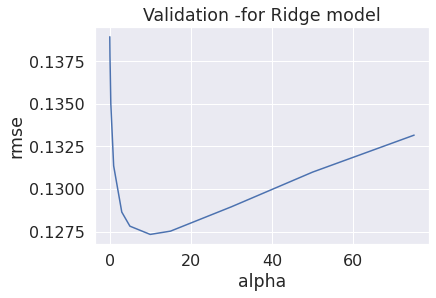

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation -for Ridge model")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()

models_scores.append(['RidgeRegression', cv_ridge.min()])

In [ ]:

# score=rmse_cv(model_lasso).mean()
# models_scores.append(['LassoRegression',score])

1
Lasso picked 3 variables and eliminated the other 285 variables
3
0.1
Lasso picked 8 variables and eliminated the other 280 variables
8
0.001
Lasso picked 79 variables and eliminated the other 209 variables
79
0.0005
Lasso picked 110 variables and eliminated the other 178 variables
110
0.0002
Lasso picked 158 variables and eliminated the other 130 variables
158
['3', '8', '79', '110', '158']


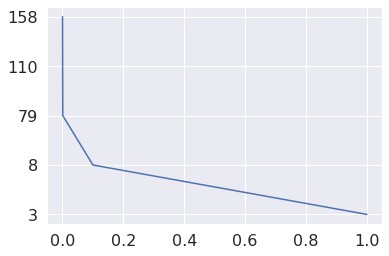

In [ ]:
l0_array = []
alphas = [1, 0.1, 0.001, 0.0005,0.0002]

for alpha in alphas: 
    l0=0
    print(alpha)
    model_lasso = LassoCV(alphas = [alpha]).fit(X_train, y)


    rmse_cv(model_lasso).mean()
    coef = pd.Series(model_lasso.coef_, index = X_train.columns)
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    #print(imp_coef)
    print(str(sum(coef != 0)))
    l0 = str(sum(coef != 0))
    '''for value in coef:
        #print(value)
        if value>0.0:

            l0= l0 + 1.0
    print("l0 norm :" + str(l0))'''
    
    l0_array.append(l0)
print(l0_array)
plt.plot(alphas, l0_array)

In [ ]:
model_lasso = LassoCV(0.0005)

model_lasso.fit(X_train,y)
y_pred_lasso=model_lasso.predict(X_test)
d = { 'Id': test.loc[:,'Id'],'SalePrice': y_pred_lasso}
print(d)
yprediction_1 = pd.DataFrame(data=d)
print(yprediction_1)
yprediction_1.to_csv("ypred_lasso_d2.csv")

{'Id': 0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64, 'SalePrice': array([11.91535396, 11.88896185, 12.03278108, ..., 12.08521852,
       11.77724315, 12.44541016])}
        Id  SalePrice
0     1461  11.915354
1     1462  11.888962
2     1463  12.032781
3     1464  12.182499
4     1465  12.228541
...    ...        ...
1454  2915  11.366780
1455  2916  11.645279
1456  2917  12.085219
1457  2918  11.777243
1458  2919  12.445410

[1459 rows x 2 columns]


In [ ]:
from sklearn.metrics import r2_score

y_pred_lasso=pd.DataFrame(model_lasso.predict(X_train))
# print(y_pred_lasso)
r2_score(y, y_pred_lasso)



0.8183875162214399

In [ ]:
model_ridge.fit(X_train,y)

y_pred_ridge=model_ridge.predict(X_train)
# print(y_pred_ridge)
r2_score(y, y_pred_ridge)

0.9467796208959164

In [ ]:
import pandas as pd
Xtrain_modified=X_train.copy()

Xtrain_modified['y_pred_l']=y_pred_lasso
Xtrain_modified['y_lasso']=y_pred_lasso

In [ ]:
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(Xtrain_modified,y)
y_pred_f=model_ridge.predict(Xtrain_modified)
r2_score(y, y_pred_f)


0.9467796212943842

In [ ]:
random_state = 42
n_jobs = -1

In [ ]:
elastic_net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio= .9, random_state= random_state))
kernel_ridge= KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
xgb_regressor= xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,verbosity=0, nthread = -1, random_state = random_state)
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state= random_state))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

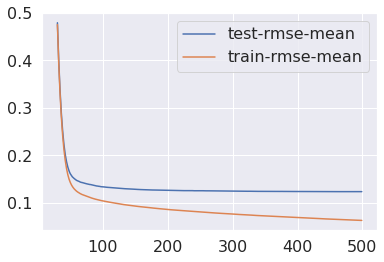

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))

In [ ]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":xgb_preds})
solution.to_csv("ridge_sol.csv", index = False)

In [ ]:
estimators = [ ('elastic_net', elastic_net), ('kernel_ridge', kernel_ridge),('xgb_regressor', xgb_regressor) ]

stack = StackingRegressor(estimators=estimators, final_estimator= lasso, cv= 5, n_jobs= n_jobs, passthrough = True)

stack.fit(X_train, y)

pred_stack = np.expm1(stack.predict(X_test))
                
solution = pd.DataFrame({"id":test.Id, "SalePrice":pred_stack})
solution.to_csv("stack_sol.csv", index = False)
